## Importações

In [520]:
%matplotlib inline

import sys
import lumapi
import os
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.constants import c


In [521]:
inter = lumapi.INTERCONNECT()

In [522]:
um = 1e-6
nm = 1e-9

delta_L = [553.97536458,  55.39753646,  27.69876823]

Com o uso de Y-Branch na entrada e saída do MZI, não é possível obter, em uma única simulação, transmissões defasadas (assim como observado em MZI com saída utilizando acoplador direcional). Para isso, é somada uma parcela $x$ ao $\Delta L$, onde:

$$x = \frac{\lambda}{2n_{eff}}$$

In [523]:
lamb = 1550*nm
neff = 2.353696366632936
x_transmissao_defasada = lamb/(2*neff)
print(x_transmissao_defasada*1e6)

0.32926931909601875


## Criação e posicionamento dos blocos

In [524]:

inter.switchtodesign()
inter.deleteall()

inter.addelement('Optical Network Analyzer')
inter.set("number of points",1000)
inter.set("input parameter",2)
inter.set("start frequency", c/(1500*nm))
inter.set("stop frequency", c/(1600*nm))

guia_menor = 50*um

# 1 - ideal
# 2 - simulado
# 3 - pdk
caso = 3
#delta_L[0] 1um
#delta_L[1] 10um
#delta_L[2] 20um

delta_L = delta_L[2]

if (caso == 1):
    inter.addelement('Waveguide Y Branch')
    inter.set("name", "Y1")

    inter.select("Y1")
    inter.copy()
    inter.set("name","Y2")
    inter.rotateelement("Y2")
    inter.rotateelement("Y2")

    inter.addelement('Straight waveguide')
    inter.set("name", "Guia_1")
    inter.set("length",guia_menor)
    inter.set("effective index 1", 2.35400)
    inter.set("group index 1", 4.33683)

    inter.addelement('Straight waveguide')
    inter.set("name", "Guia_2")
    inter.set("length",guia_menor + delta_L*um  + x_transmissao_defasada)
    inter.set("effective index 1", 2.35400)
    inter.set("group index 1", 4.33683)

elif (caso == 2):
    inter.addelement("Optical N Port S-Parameter")
    inter.set("name", "Y1")
    inter.set("load from file", 1)
    inter.set("s parameters filename", r"C:\Users\gson5\Downloads\ERICK TRALHAS\FOTÔNICA\LAB. 7\te.dat")

    inter.select("Y1")
    inter.copy()
    inter.set("name","Y2")
    inter.rotateelement("Y2")
    inter.rotateelement("Y2")

    inter.addelement("MODE Waveguide")
    inter.set("name", "Guia_1")
    inter.set("ldf filename", r"C:\Users\gson5\Downloads\ERICK TRALHAS\FOTÔNICA\LAB. 10 - MZI\GUIA.ldf")
    inter.set("length", guia_menor + delta_L*um)

    inter.select("Guia_1")
    inter.copy()
    inter.set("name","Guia_2")
    inter.set("length", guia_menor)
elif (caso == 3):
    inter.expressioncheckoff()
    inter.addelement("ebeam_y_1550")
    inter.set("name", "Y1")

    inter.select("Y1")
    inter.copy()
    inter.set("name","Y2")
    inter.rotateelement("Y2")
    inter.rotateelement("Y2")

    inter.addelement('ebeam_wg_integral_1550')
    inter.set("name", "Guia_1")
    inter.set("annotate", False)
    inter.set("wg_length", guia_menor + delta_L*um )
    inter.set("wg_width", 450e-9)

    inter.addelement('ebeam_wg_integral_1550')
    inter.set("name", "Guia_2")
    inter.set("annotate", False)
    inter.set("wg_length", guia_menor)
    inter.set("wg_width", 450e-9)

inter.setposition("ONA_1",0,0)
inter.setposition("Y1",-200,250)
inter.setposition("Y2",200,250)
inter.setposition("Guia_1",0,175)
inter.setposition("Guia_2",0,325)


## Conexão dos blocos

In [525]:
if(caso == 1):
    inter.connect("Y1", "port 2", "Guia_1", "port 1")
    inter.connect("Y1", "port 3", "Guia_2", "port 1")
    inter.connect("Guia_1", "port 2", "Y2", "port 3")
    inter.connect("Guia_2", "port 2", "Y2", "port 2")
    inter.connect("ONA_1", "output", "Y1", "port 1")
    inter.connect("ONA_1", "input 1", "Y2", "port 1")

elif(caso == 2):
    inter.connect("Y1", "out 1", "Guia_1", "port 1")
    inter.connect("Y1", "out 2", "Guia_2", "port 1")
    inter.connect("Guia_1", "port 2", "Y2", "out 2")
    inter.connect("Guia_2", "port 2", "Y2", "out 1")
    inter.connect("ONA_1", "output", "Y1", "in")
    inter.connect("ONA_1", "input 1", "Y2", "in")
elif(caso == 3):
    inter.connect("Y1", "opt_b1", "Guia_1", "port 1")
    inter.connect("Y1", "opt_b2", "Guia_2", "port 1")
    inter.connect("Guia_1", "port 2", "Y2", "opt_b2")
    inter.connect("Guia_2", "port 2", "Y2", "opt_b1")
    inter.connect("ONA_1", "output", "Y1", "opt_a1")
    inter.connect("ONA_1", "input 1", "Y2", "opt_a1")    

In [526]:
inter.run()

## Obtenção de resultados

In [527]:
if (caso == 1):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['TE gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["TE free spectral range (m)"]

elif (caso == 2):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['mode 1 gain (dB)'])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["mode 1 free spectral range (m)"]
    
elif (caso == 3):
    TE_gain = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")["'TE' gain (dB)"])
    FSR1 = inter.getresult("ONA_1","input 1/mode 1/peak/free spectral range")
    fsr_wv= np.squeeze(FSR1['wavelength'])
    FSR1 = FSR1["'TE' free spectral range (m)"]

comprimentos_de_onda = np.squeeze(inter.getresult("ONA_1","input 1/mode 1/gain")['wavelength'])

<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\D'
<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:4: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_17916\1578903432.py:3: SyntaxWarning: invalid escape sequence '\D'
  plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_17916\1578903432.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L:.3f} $\mu$")
C:\Users\gson5\AppData\Local\Temp\ipykernel_17916\1578903432.py:4: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)


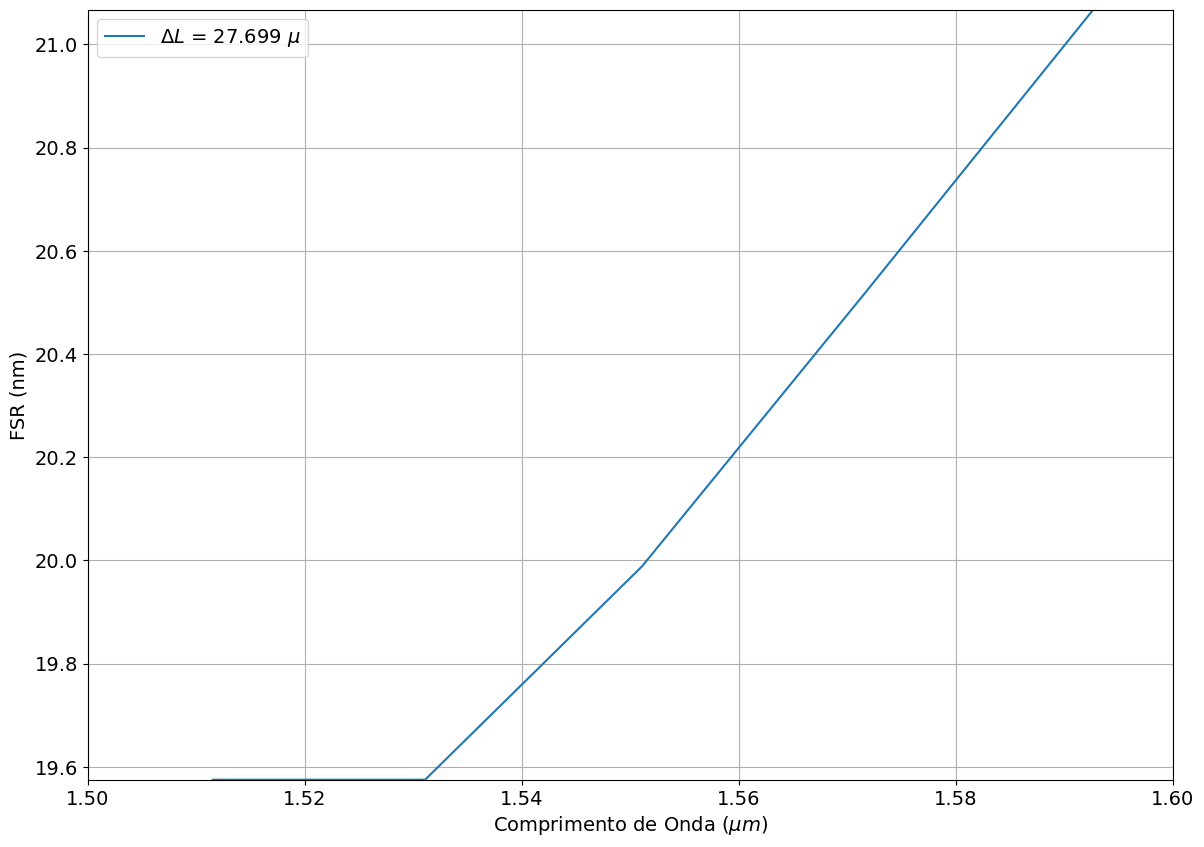

In [528]:
plt.figure(figsize=(14,10))

plt.plot(fsr_wv*1e6,FSR1*1e9, label = f"$\Delta L$ = {delta_L:.3f} $\mu$")
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('FSR (nm)', fontsize = 14)

plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.5,1.6)
plt.ylim(min(FSR1*1e9) ,max(FSR1*1e9))

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

plt.savefig('FSR 20nm PDK.png')
plt.show()

In [529]:
"""
plt.figure(figsize=(14,10))

plt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = 20 nm, L = {(guia_menor + delta_L*um)*1e6:.3f} $\mu$")
# plt.plot(comprimentos_de_onda*1e6,TE_gain1, label = f'FSR = 20 nm, L = {(guia_menor + delta_L*um +x_transmissao_defasada)*1e6:.3f} $\mu$')
plt.xlabel('Comprimento de Onda $(\mu m)$', fontsize = 14)
plt.ylabel('Transmissão (dB)', fontsize = 14)

plt.axhline(y=-3, linestyle='--', color ="g",label = '-3 dB')

plt.tick_params(axis='both', labelsize=14)

plt.xlim(1.5,1.6)
plt.ylim(min(TE_gain) - 1 ,1)

plt.legend(loc = "best", fontsize = 14)

plt.grid(True)

#plt.savefig('GANHO IDEAL FSR 20nm E DEFASADO.png')
plt.show()
"""

<>:1: SyntaxWarning: invalid escape sequence '\m'
<>:1: SyntaxWarning: invalid escape sequence '\m'
C:\Users\gson5\AppData\Local\Temp\ipykernel_17916\3650111988.py:1: SyntaxWarning: invalid escape sequence '\m'
  """


'\nplt.figure(figsize=(14,10))\n\nplt.plot(comprimentos_de_onda*1e6,TE_gain, label = f"FSR = 20 nm, L = {(guia_menor + delta_L*um)*1e6:.3f} $\\mu$")\n# plt.plot(comprimentos_de_onda*1e6,TE_gain1, label = f\'FSR = 20 nm, L = {(guia_menor + delta_L*um +x_transmissao_defasada)*1e6:.3f} $\\mu$\')\nplt.xlabel(\'Comprimento de Onda $(\\mu m)$\', fontsize = 14)\nplt.ylabel(\'Transmissão (dB)\', fontsize = 14)\n\nplt.axhline(y=-3, linestyle=\'--\', color ="g",label = \'-3 dB\')\n\nplt.tick_params(axis=\'both\', labelsize=14)\n\nplt.xlim(1.5,1.6)\nplt.ylim(min(TE_gain) - 1 ,1)\n\nplt.legend(loc = "best", fontsize = 14)\n\nplt.grid(True)\n\n#plt.savefig(\'GANHO IDEAL FSR 20nm E DEFASADO.png\')\nplt.show()\n'

In [530]:
##inter.close()